# Laboratorio 5

En este laboratorio vamos a aplicar lo visto sobre redes convolucionales a dos datasets tradicionales: [MNIST](https://en.wikipedia.org/wiki/MNIST_database) y [CIFAR10](https://en.wikipedia.org/wiki/CIFAR-10)



In [ ]:
import time
import torch
import itertools
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Creamos los datasets
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor()
])


train_dataset = MNIST("", train=True, download=True, transform=transform)
test_dataset = MNIST("", train=False, download=True, transform=transform)

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw




Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


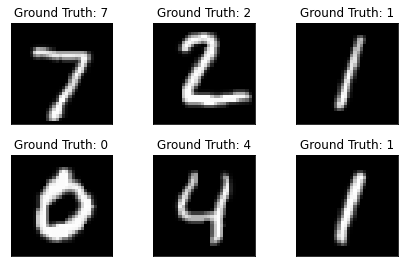

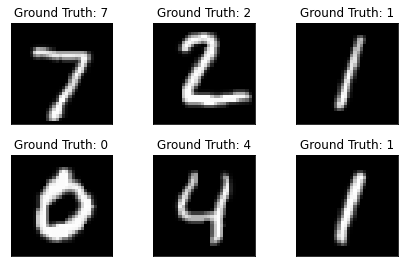

In [ ]:
example_loader = torch.utils.data.DataLoader(test_dataset, batch_size=6)

examples = enumerate(example_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Modelo

Implementar LeNet (cambiando tanh por ReLU) y un modelo lineal para comparar (tener en cuenta para este caso achatar las imagenes a un vector).

Traten de lograr un modelo lineal con un número comparable de parametros para que las comparaciones sean mas justas.  


***

LeNet:



![Image](https://engmrk.com/wp-content/uploads/2018/09/LeNEt_Summary_Table.jpg)





In [ ]:
class LeNet(nn.Module):
  def __init__(self, in_channels):
    # in_channels: int, cantidad de canales de la imagen original
    super(LeNet, self).__init__()
    # Su implementacion
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1, padding=0)
    self.pooling = nn.AvgPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0)
    self.fc1 = nn.Linear(in_features=120, out_features=84)
    self.output = nn.Linear(in_features=84, out_features=10)
  
  def forward(self, x):
    # NO ES NECESARIO AGREGAR SOFTMAX A LA SALIDA!
    res = torch.relu(self.conv1(x))
    res = self.pooling(res)
    res = torch.relu(self.conv2(res))
    res = self.pooling(res)
    res = torch.relu(self.conv3(res))
    
    # Aca los tengo que "achatar"
    # Los achato en direccion de los filtros, no del batch!!
    res = res.flatten(1)

    logits = torch.relu(self.fc1(res))
    return self.output(logits)



class LinearModel(nn.Module):
  def __init__(self, images_size):
    # images_size: int, tamaño de imagenes (32 para mnist)
    super(LinearModel, self).__init__()
    # Su implementacion
    self.fc1 = nn.Linear(in_features=images_size**2, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=128)
    self.output = nn.Linear(in_features=128, out_features=10)
  
  def forward(self, x):
    # NO ES NECESARIO AGREGAR SOFTMAX A LA SALIDA!
    res = F.relu(self.fc1(x.flatten(1)))
    res = F.relu(self.fc3(res))
    
    return self.output(res) 


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


le_net = LeNet(1)
print(f"LeNet parameters: {count_parameters(le_net)}")


linear_model = LinearModel(32)
print(f"Linear parameters: {count_parameters(linear_model)}")

LeNet parameters: 61706
Linear parameters: 149002


# Entrenamiento y Test

Entrene ambos modelos y compare su performance (Accuracy) en MNIST usando CrossEntropy como función de costo y Adam como optimizador.

Recuerde definir los hyperparámetros como le parezcan adecuados.


In [ ]:
# Hyperparameters
BATCH_SIZE = 32
LR = 0.001
NUMBER_EPOCHS = 10

modelo = LeNet(1).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(modelo.parameters(), lr=LR)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)

# Que utilidad tienen pin_memory, shuffle y num_workers?

In [ ]:
def train_epoch(training_model, loader, criterion, optim):
    training_model.train()
    epoch_loss = 0
    
    all_labels = []
    all_predictions = []
    for images, labels in loader:
        all_labels.extend(labels.numpy())
        
        optim.zero_grad()
        
        predictions = training_model(images.to(device))
        all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())
        
        labels = labels.long()
        loss = criterion(predictions, labels.to(device))

        loss.backward()
        optim.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100


def validation_epoch(val_model, loader, criterion):
    val_model.eval()
    val_loss = 0
    
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in loader:
            predictions = val_model(images.to(device))
            labels = labels.long()
            loss = criterion(predictions, labels.to(device))
            
            val_loss += loss.item()
            
            all_targets.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.topk(1, dim=1)[1].cpu().numpy().tolist())

    accuracy = accuracy_score(all_targets, all_predictions)
    
    return val_loss / len(loader), accuracy * 100

In [ ]:
train_history = []
test_history = []
accuracy_history = []

for epoch in range(NUMBER_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train_epoch(modelo, train_loader, criterion, optimizer)
    train_history.append(train_loss)
    print("Training epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds"
          .format(epoch + 1, train_loss, train_acc, time.time() - start_time))

    start_time = time.time()
    test_loss, acc = validation_epoch(modelo, test_loader, criterion)
    test_history.append(test_loss)
    accuracy_history.append(acc)
    print("Test epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds"
          .format(epoch + 1, test_loss, acc, time.time() - start_time))

Training epoch 1 | Loss 2.302655 | Accuracy 10.30% | Time 10.10 seconds
Test epoch 1 | Loss 2.300340 | Accuracy 10.28% | Time 1.41 seconds
Training epoch 2 | Loss 2.298090 | Accuracy 10.44% | Time 9.88 seconds
Test epoch 2 | Loss 2.295455 | Accuracy 10.28% | Time 1.45 seconds
Training epoch 3 | Loss 2.291769 | Accuracy 11.53% | Time 9.84 seconds
Test epoch 3 | Loss 2.286453 | Accuracy 16.95% | Time 1.43 seconds
Training epoch 4 | Loss 2.276693 | Accuracy 26.21% | Time 9.88 seconds
Test epoch 4 | Loss 2.260510 | Accuracy 33.67% | Time 1.44 seconds
Training epoch 5 | Loss 2.206293 | Accuracy 36.67% | Time 9.91 seconds
Test epoch 5 | Loss 2.079631 | Accuracy 41.22% | Time 1.44 seconds
Training epoch 6 | Loss 1.533462 | Accuracy 57.43% | Time 9.92 seconds
Test epoch 6 | Loss 0.863222 | Accuracy 76.91% | Time 1.53 seconds
Training epoch 7 | Loss 0.639377 | Accuracy 81.96% | Time 9.91 seconds
Test epoch 7 | Loss 0.499555 | Accuracy 85.54% | Time 1.45 seconds
Training epoch 8 | Loss 0.474011 

# Que pasa ahora si exploramos CIFAR10?
